# Final Project Phase 3 Summary
This Jupyter Notebook (.ipynb) will serve as the skeleton file for your submission for Phase 3 of the Final Project. Complete all sections below as specified in the instructions for the project, covering all necessary details. We will use this to grade your individual code (Do this whether you are in a group or not). Good luck! <br><br>

Note: To edit a Markdown cell, double-click on its text.

## Jupyter Notebook Quick Tips
Here are some quick formatting tips to get you started with Jupyter Notebooks. This is by no means exhaustive, and there are plenty of articles to highlight other things that can be done. We recommend using HTML syntax for Markdown but there is also Markdown syntax that is more streamlined and might be preferable. 
<a href = "https://towardsdatascience.com/markdown-cells-jupyter-notebook-d3bea8416671">Here's an article</a> that goes into more detail. (Double-click on cell to see syntax)

# Heading 1
## Heading 2
### Heading 3
#### Heading 4
<br>
<b>BoldText</b> or <i>ItalicText</i>
<br> <br>
Math Formulas: $x^2 + y^2 = 1$
<br> <br>
Line Breaks are done using br enclosed in < >.
<br><br>
Hyperlinks are done with: <a> https://www.google.com </a> or 
<a href="http://www.google.com">Google</a><br>

# Data Collection and Cleaning


Transfer/update the data collection and cleaning you created for Phase II below. You may include additional cleaning functions if you have extra datasets. If no changes are necessary, simply copy and paste your phase II parsing/cleaning functions.


## Downloaded Dataset Requirement



In [2]:
def data_parser():
  #Downloaded Dataset for Unemployment rates
  import pandas as pd

  # Load the dataset
  file_path = '/Users/vedsanjanwala/Documents/CS 2316/Dataset Unemployment filter/Unemoloyment data.M.csv'
  data = pd.read_csv(file_path)

  # Choose whether to use calendar or seasonally adjusted data
  use_seasonally_adjusted = True  

  # Filter based on seasonally adjusted or calendar data
  if use_seasonally_adjusted:
      data = data[data['ADJUSTMENT'] == 'Y']
  else:
      data = data[data['ADJUSTMENT'] == 'N']

  # Filter the data based on the given conditions
  filtered_data = data[(data['Sex'] == 'Total') & (data['Age'] == '15 years or over')][['Sex', 'Age', 'TIME_PERIOD', 'OBS_VALUE', 'ADJUSTMENT']]

  # Convert TIME_PERIOD to datetime to facilitate sorting
  filtered_data['TIME_PERIOD'] = pd.to_datetime(filtered_data['TIME_PERIOD'])

  # Filter to include only data after a certain year (e.g., after 1990)
  filtered_data = filtered_data[filtered_data['TIME_PERIOD'].dt.year >= 1999]

  # Sort the data by TIME_PERIOD
  filtered_data = filtered_data.sort_values(by='TIME_PERIOD')

  # Calculate the percentage change from the previous month and limit it to two decimals
  filtered_data['PCT_CHANGE'] = (filtered_data['OBS_VALUE'].pct_change() * 100).round(2)

  # **Remove the first row which will always have "No Change" in PCT_CHANGE**
  filtered_data = filtered_data.dropna(subset=['PCT_CHANGE'])

  # Add a new column to indicate if the percentage change was negative or positive
  filtered_data['CHANGE_INDICATOR'] = filtered_data['PCT_CHANGE'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'No Change'))

  # Rename the OBS_VALUE column to "Unemployment in Thousands"
  filtered_data = filtered_data.rename(columns={'OBS_VALUE': 'Unemployment in Thousands'})

  # Reset the index
  filtered_data = filtered_data.reset_index(drop=True)

  # Display the filtered data
  filtered_data.head()
  filtered_data.to_csv('/Users/vedsanjanwala/Documents/CS 2316/Dataset Unemployment filter/Filtered_Unemployment_Data.csv', index=False)
  print(filtered_data)





############ Function Call ############
data_parser()

       Sex               Age TIME_PERIOD  Unemployment in Thousands  \
0    Total  15 years or over  1999-02-01                       6111   
1    Total  15 years or over  1999-03-01                       5783   
2    Total  15 years or over  1999-04-01                       6004   
3    Total  15 years or over  1999-05-01                       5796   
4    Total  15 years or over  1999-06-01                       5951   
..     ...               ...         ...                        ...   
300  Total  15 years or over  2024-02-01                       6458   
301  Total  15 years or over  2024-03-01                       6429   
302  Total  15 years or over  2024-04-01                       6492   
303  Total  15 years or over  2024-05-01                       6649   
304  Total  15 years or over  2024-06-01                       6811   

    ADJUSTMENT  PCT_CHANGE CHANGE_INDICATOR  
0            Y        2.26         Positive  
1            Y       -5.37         Negative  
2        

## Web Collection Requirement \#1


In [3]:
def web_parser1():
    ##HTML Web scrape for all CPI data
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import os

    # Define the filter date
    filter_year = 1999
    filter_month = 12

    # URL to fetch the main page
    main_url = 'https://www2.nhes.nh.gov/GraniteStats/SessionServlet?page=CPI.jsp&SID=5&country=000000&countryName=United%20States'

    # Get the main page content
    main_response = requests.get(main_url)
    main_response.raise_for_status()
    main_soup = BeautifulSoup(main_response.content, 'html.parser')

    # Example: Extracting some metadata or additional content from the main page
    # Here we just print the title of the page
    print(main_soup.title.string)

    # Fetch the actual data from the identified data endpoint
    data_url = 'https://www2.nhes.nh.gov/GraniteStats/CpiServlet'
    params = {
        'page': 'CPI.jsp',
        'source': '01',  # Adjust this value as necessary
        'country': '000000',
        # Add any other required parameters here
    }

    # Send a request to fetch the content
    response = requests.get(data_url, params=params)
    response.raise_for_status()

    # Process the data if the request was successful
    data = response.text
    rows = data.split('~')

    # Initialize lists to store the data
    date_periods = []
    cpi_values = []
    over_the_year_changes = []
    over_the_month_changes = []

    # Process each row
    for row in rows:
        if row.strip() == "":
            continue
        cols = row.split(',,')
        if len(cols) < 5:
            continue
        year, period, cpi_value, over_the_year_change, over_the_month_change = cols[:5]
        
        # Combine Year and Period into a single column
        year = int(year.strip())
        month = int(period.strip().replace('M', ''))
        date_period = f"{year}-{month}"
        
        # Append the data to the lists if the date is after the filter date
        if (year > filter_year) or (year == filter_year and month > filter_month):
            date_periods.append(date_period)
            cpi_values.append(float(cpi_value.strip()))
            over_the_year_changes.append(float(over_the_year_change.strip().replace('%', '')))
            over_the_month_changes.append(float(over_the_month_change.strip().replace('%', '')))

    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'Date': date_periods,
        'Consumer Price Index': cpi_values,
        'Over-the-Month Percent Change': over_the_month_changes
    })

    # Sort the DataFrame from bottom up
    df = df.iloc[::-1].reset_index(drop=True)

    # Add a new column for positive/negative change
    df['Change Label'] = df['Over-the-Month Percent Change'].apply(lambda x: 'positive' if x > 0 else 'negative')

    # Save the DataFrame to a CSV file in the Documents folder
    documents_path = os.path.expanduser('/Users/vedsanjanwala/Documents/CS 2316/Dataset CPI index')
    csv_file_path = os.path.join(documents_path, 'cpi_data_sorted_filtered.csv')
    df.to_csv(csv_file_path, index=False)
    print(df)





############ Function Call ############
web_parser1()

CPI.jsp
       Date  Consumer Price Index  Over-the-Month Percent Change Change Label
0    2000-1                 168.8                            0.3     positive
1    2000-2                 169.8                            0.6     positive
2    2000-3                 171.2                            0.8     positive
3    2000-4                 171.3                            0.1     positive
4    2000-5                 171.5                            0.1     positive
..      ...                   ...                            ...          ...
289  2024-2                 310.3                            0.6     positive
290  2024-3                 312.3                            0.6     positive
291  2024-4                 313.5                            0.4     positive
292  2024-5                 314.1                            0.2     positive
293  2024-6                 314.2                            0.0     negative

[294 rows x 4 columns]


## Web Collection Requirement #2

In [1]:
def web_parser2():
  ##Stockdata to CSV file
  import requests
  import pandas as pd
  import os

  api_key = '#'
  base_url = 'https://www.alphavantage.co/query'
  symbols = ['AAPL', 'TSLA', 'PLD', 'AMZN', 'JPM']
  function = 'TIME_SERIES_MONTHLY'
  documents_path = os.path.expanduser('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter')

  for symbol in symbols:
      params = {
          'function': function,
          'symbol': symbol,
          'apikey': api_key,
          'datatype': 'json'
      }
      
      response = requests.get(base_url, params=params)
      response.raise_for_status()
      
      data = response.json()
      monthly_data = data['Monthly Time Series']
      
      df = pd.DataFrame.from_dict(monthly_data, orient='index')
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      df.index.name = 'date'
      df.reset_index(inplace=True)
      
      df['date'] = pd.to_datetime(df['date'])
      df.sort_values('date', inplace=True)
      
      df = df[df['date'] >= '1990-01-01']
      
      df['close'] = df['close'].astype(float)
      df['% change'] = df['close'].pct_change() * 100
      df = df.round({'price': 2, '% change': 2})
      df['positive/negative'] = df['% change'].apply(lambda x: 'positive' if x > 0 else 'negative')
      df['symbol'] = symbol
      df['date'] = df['date'].dt.strftime('%Y-%m')
      df = df[['date', 'symbol', 'close', '% change', 'positive/negative']]
      df.rename(columns={'close': 'price'}, inplace=True)
      
      csv_file_path = os.path.join(documents_path, f'stock_data_{symbol}.csv')
      df.to_csv(csv_file_path, index=False)
      print(df)






############ Function Call ############
web_parser2()

        date symbol   price  % change positive/negative
295  1999-12   AAPL  102.81       NaN          negative
294  2000-01   AAPL  103.75      0.91          positive
293  2000-02   AAPL  114.62     10.48          positive
292  2000-03   AAPL  135.81     18.49          positive
291  2000-04   AAPL  124.06     -8.65          negative
..       ...    ...     ...       ...               ...
4    2024-03   AAPL  171.48     -5.13          negative
3    2024-04   AAPL  170.33     -0.67          negative
2    2024-05   AAPL  192.25     12.87          positive
1    2024-06   AAPL  210.62      9.56          positive
0    2024-07   AAPL  217.96      3.48          positive

[296 rows x 5 columns]
        date symbol    price  % change positive/negative
168  2010-07   TSLA   19.940       NaN          negative
167  2010-08   TSLA   19.480     -2.31          negative
166  2010-09   TSLA   20.405      4.75          positive
165  2010-10   TSLA   21.840      7.03          positive
164  2010-11   TSLA

#Inconsistency Revisions
 **If you were requested to revise your inconsistency section from Phase II, enter your responses here. Otherwise, ignore this section.**

For each inconsistency (NaN, null, duplicate values, empty strings, etc.) you discover in your datasets, write at least 2 sentences stating the significance, how you identified it, and how you handled it.

1. 

2. 

3. 

4. (if applicable)

5. (if applicable)


## Data Sources

Include sources (as links) to your datasets. If any of these are different from your sources used in Phase II, please <b>clearly</b> specify.

*   Downloaded Dataset Source:
*   Web Collection #1 Source:
*   Web Collection #2 Source:



# Data Analysis
For the Data Analysis section, you are required to utilize your data to complete the following:

*   Create at least 5 insights
*   Generate at least 3 data visualizations
*   Export aggregated data to at least 1 summary file 

Create a function for each of the following sections mentioned above. Do not forget to fill out the explanation section for each function. 

Make sure your data analysis is not too simple. Performing complex aggregation and using modules not taught in class shows effort, which will increase the chance of receiving full credit. 

# Graphical User Interface (GUI) Implementation
If you decide to create a GUI for Phase II, please create a separate Python file (.py) to build your GUI. You must submit both the completed PhaseII.ipynb and your Python GUI file.

## Insights

  Stock  Correlation Coefficient     Slope   Intercept   R Value  \
0  AAPL                 0.500053  0.024617  -44.008839  0.500053   
1  AMZN                -0.018578 -0.005742  653.085380 -0.018578   
2   JPM                -0.364050 -0.005062  114.752650 -0.364050   
3  TSLA                -0.156050 -0.012866  415.792313 -0.156050   
4   PLD                -0.330781 -0.003752   88.522872 -0.330781   

        P Value  Standard Error  
0  4.537437e-20        0.002491  
1  7.506727e-01        0.018055  
2  1.127048e-10        0.000757  
3  4.339037e-02        0.006321  
4  5.816918e-09        0.000625  


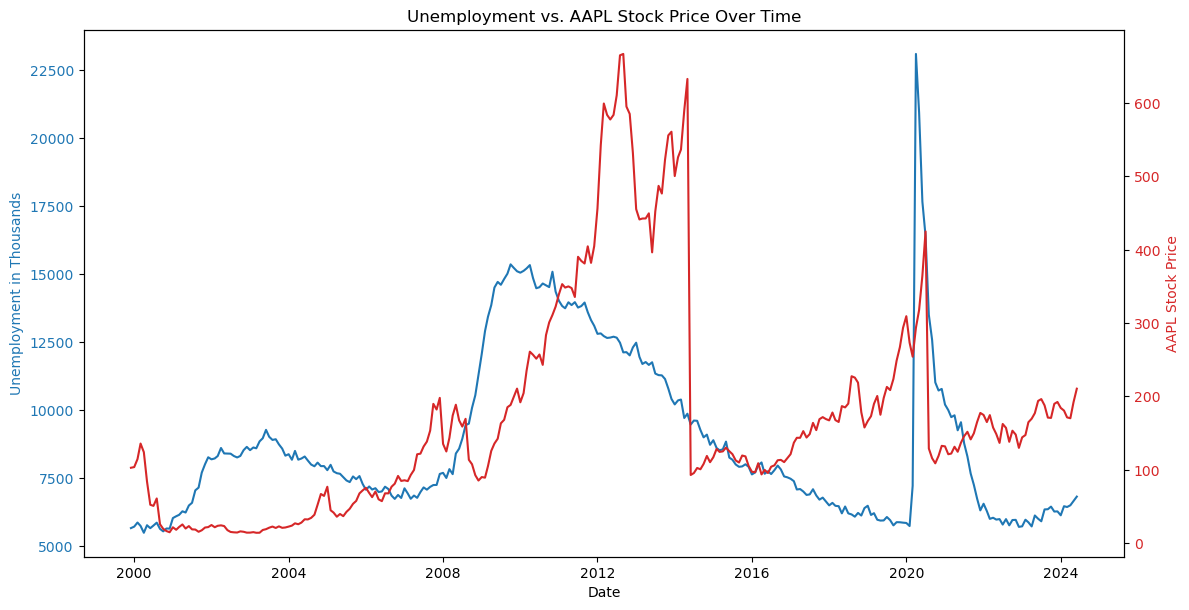

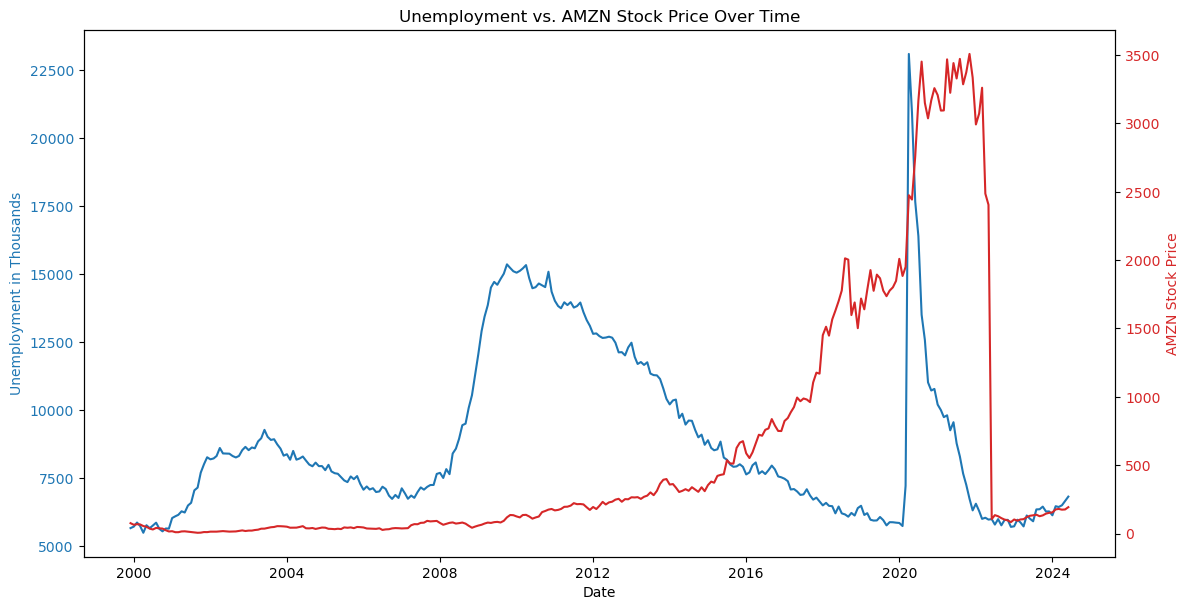

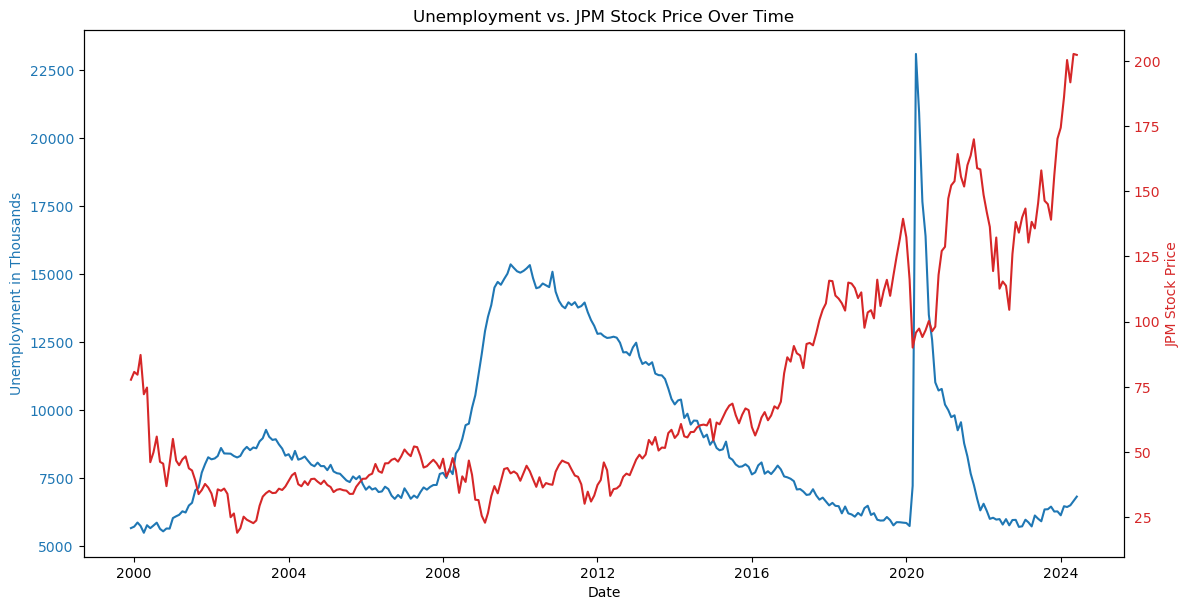

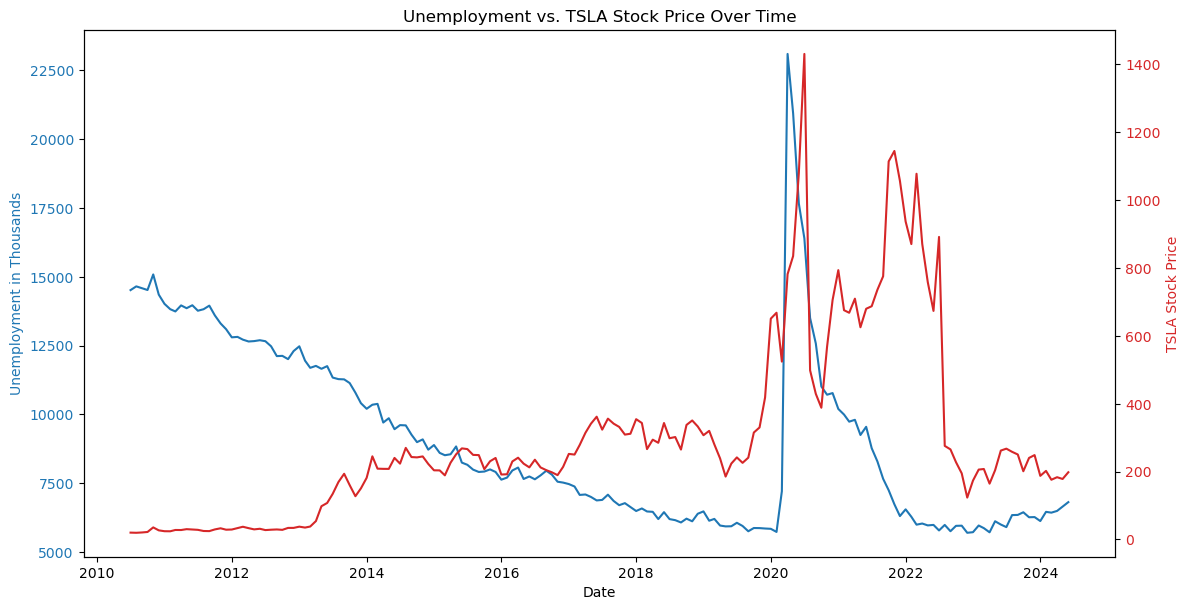

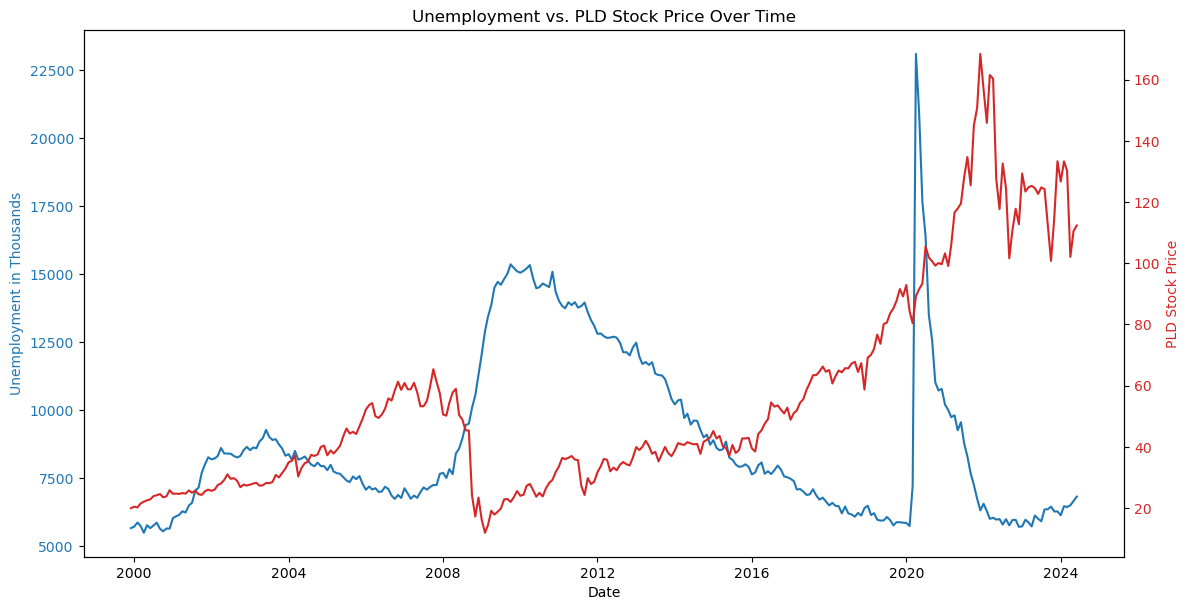

In [22]:
def insight1():
  import pandas as pd
  import os
  import matplotlib.pyplot as plt
  import seaborn as sns
  from scipy.stats import linregress

  # Insight 1: Correlation between Unemployment Rate and Stock Market Performance (for all stocks in all sectors)

  unemployment_data_path = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Dataset Unemployment filter/Filtered_Unemployment_Data.csv'
  stock_data_directory = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter'

  stock_files = ['stock_data_AAPL.csv', 'stock_data_AMZN.csv', 'stock_data_JPM.csv', 'stock_data_TSLA.csv', 'stock_data_PLD.csv']
  stock_files = [os.path.join(stock_data_directory, file) for file in stock_files]

  unemployment_data = pd.read_csv(unemployment_data_path)
  unemployment_data['TIME_PERIOD'] = pd.to_datetime(unemployment_data['TIME_PERIOD'])

  results = []

  for stock_file in stock_files:
      if not os.path.isfile(stock_file):
          raise FileNotFoundError(f"Stock data file not found: {stock_file}")

      stock_data = pd.read_csv(stock_file)
      stock_data['date'] = pd.to_datetime(stock_data['date'])
      stock_symbol = os.path.basename(stock_file).split('_')[2].split('.')[0]
      
      merged_data = pd.merge(unemployment_data, stock_data, left_on='TIME_PERIOD', right_on='date')

      correlation = merged_data['Unemployment in Thousands'].corr(merged_data['price'])
      slope, intercept, r_value, p_value, std_err = linregress(merged_data['Unemployment in Thousands'], merged_data['price'])

      results.append({
          'Stock': stock_symbol,
          'Correlation Coefficient': correlation,
          'Slope': slope,
          'Intercept': intercept,
          'R Value': r_value,
          'P Value': p_value,
          'Standard Error': std_err
      })

  results_df = pd.DataFrame(results)
  print(results_df)

    ##Graph of Stock and Unemployment vs Time
  for stock_file in stock_files:
        stock_data = pd.read_csv(stock_file)
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_symbol = os.path.basename(stock_file).split('_')[2].split('.')[0]
        
        merged_data = pd.merge(unemployment_data, stock_data, left_on='TIME_PERIOD', right_on='date')

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.set_xlabel('Date')
        ax1.set_ylabel('Unemployment in Thousands', color='tab:blue')
        ax1.plot(merged_data['TIME_PERIOD'], merged_data['Unemployment in Thousands'], color='tab:blue', label='Unemployment')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.set_ylabel(f'{stock_symbol} Stock Price', color='tab:red')
        ax2.plot(merged_data['TIME_PERIOD'], merged_data['price'], color='tab:red', label=f'{stock_symbol} Stock Price')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        fig.tight_layout()
        plt.title(f'Unemployment vs. {stock_symbol} Stock Price Over Time')
        plt.show()


############ Function Call ############
insight1()

### Insight 1 Explanation

My first insight is using statistical analysis in order to compare the Unemployment index with the underlying stock in 5 major sectors. I do this using 6 important statistica; metrics. These metrics are the Corrolation Coefficant, the slope, the intercept, the r-value, and the standard error. Here is what the most important represent:   


Correlation Coefficient: Determines how "correlated" 2 values are, meaning how negatively or positvely their data is related. The closer to -1,1 it is the more correlated the data

Slope: More than anything tells us the direction of the trend, if it is negative we can assume the relationship is inverse, and if positive then the relationship is direct

P-Value: Tells us how statistically significant our combined data is, usually any value less than 0.05 is good

Analzying our data using these metrics we can see that all of our data is statistically signifcant to some degree. Analzying the trends we see that almost every company has a NEGATIVE correlation coefficant, meaning that the the data is inversely related. This inverse relation is further confirmed by the slope, and implies basically that when unemployment goes up, the company stock goes down, and so on. This is true for all companies but AAPL, who significantly thrives in the face of unemployment booms with a POSITIVE .5 correlation coefficant.

Furthermore, there seems to be an exception to our general data trends, during Covid-19 years, it seems like TSLA, AMZN, and APPL all significantly increased as stocks, which would point towards trends and insights into online shopping, people possibly having more money, and furthermore, despite greater unemployment.


In [15]:
def insight2():
  import pandas as pd
  import os

  ##Insight 2: The greatest average percentage change of a stock, by month(Examining the best time to invest)
  stock_data_directory = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter'
  stock_files = ['stock_data_AAPL.csv', 'stock_data_AMZN.csv', 'stock_data_JPM.csv', 'stock_data_TSLA.csv', 'stock_data_PLD.csv']
  stock_files = [os.path.join(stock_data_directory, file) for file in stock_files]

  monthly_changes = []

  for stock_file in stock_files:
      if not os.path.isfile(stock_file):
          raise FileNotFoundError(f"Stock data file not found: {stock_file}")

      stock_data = pd.read_csv(stock_file)
      stock_data['date'] = pd.to_datetime(stock_data['date'])
      stock_data['month'] = stock_data['date'].dt.month
      stock_data['percentage_change'] = stock_data['price'].pct_change() * 100
      monthly_avg_change = stock_data.groupby('month')['percentage_change'].mean().reset_index()
      stock_symbol = os.path.basename(stock_file).split('_')[2].split('.')[0]
      monthly_avg_change['stock'] = stock_symbol
      monthly_changes.append(monthly_avg_change)

  monthly_changes_df = pd.concat(monthly_changes)

  average_monthly_changes = monthly_changes_df.groupby('month')['percentage_change'].mean().reset_index()

  month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
                7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
  average_monthly_changes['month'] = average_monthly_changes['month'].map(month_names)

  print("Average Monthly Percentage Increase in Stock Prices")
  print(average_monthly_changes)

  max_increase_month = average_monthly_changes.loc[average_monthly_changes['percentage_change'].idxmax()]
  print(f"\nThe month with the highest average percentage increase is: {max_increase_month['month']} with an average increase of {max_increase_month['percentage_change']:.2f}%")





############ Function Call ############
insight2()

Average Monthly Percentage Increase in Stock Prices
        month  percentage_change
0     January           2.717945
1    February          -0.589110
2       March           3.034070
3       April           4.161191
4         May           1.851186
5        June          -0.147898
6        July           3.817142
7      August          -0.998798
8   September          -1.247531
9     October           2.806802
10   November           4.288334
11   December           0.494696

The month with the highest average percentage increase is: November with an average increase of 4.29%


### Insight 2 Explanation

My second insight focused on figuring out the best month to invest, on average, using the stock data that I had. Using the stock data I had, I used python, my cleaned dataframes, and primarily the mean function in order to average 5 stocks in different sectors, combine their percent change by month, average them, and then analyze that data. What I found by analzying that data is that the best month it seems historically to invest has been November with an average return of 4.29, with the worst month being September, with a -1.24% return on investment, month over month. This can signify a lot of things, but one of the main insights is since these are all United-States based stocks, this increase can most liklely be attributed to increased shopping during the "start of the holiday season."

In [16]:
def insight3():
  import pandas as pd
  import os
  import matplotlib.pyplot as plt

  #Insight 3 A study into the worst years for unemployment, and overall the worst months for unemployement

  unemployment_data_path = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Dataset Unemployment filter/Filtered_Unemployment_Data.csv'

  unemployment_data = pd.read_csv(unemployment_data_path)
  unemployment_data['TIME_PERIOD'] = pd.to_datetime(unemployment_data['TIME_PERIOD'])
  unemployment_data['Year'] = unemployment_data['TIME_PERIOD'].dt.year
  unemployment_data['Month'] = unemployment_data['TIME_PERIOD'].dt.month

  worst_years = unemployment_data.groupby('Year')['Unemployment in Thousands'].mean().reset_index()
  worst_months = unemployment_data.groupby('Month')['Unemployment in Thousands'].mean().reset_index()

  month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
                7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
  worst_months['Month'] = worst_months['Month'].map(month_names)

  worst_years_sorted = worst_years.sort_values(by='Unemployment in Thousands', ascending=False).reset_index(drop=True)
  worst_months_sorted = worst_months.sort_values(by='Unemployment in Thousands', ascending=False).reset_index(drop=True)

  print("Worst Years for Employment")
  print(worst_years_sorted.head(10))

  print("\nWorst Months for Employment")
  print(worst_months_sorted)

############ Function Call ############
insight3()

Worst Years for Employment
   Year  Unemployment in Thousands
0  2010               14807.750000
1  2009               14294.500000
2  2011               13738.500000
3  2020               12951.666667
4  2012               12499.166667
5  2013               11457.166667
6  2014                9601.500000
7  2008                8948.166667
8  2003                8770.333333
9  2021                8626.583333

Worst Months for Employment
        Month  Unemployment in Thousands
0       April                9121.038462
1         May                9040.115385
2        June                8938.423077
3        July                8913.520000
4      August                8822.440000
5   September                8716.080000
6     October                8658.920000
7    November                8642.400000
8    December                8588.440000
9     January                8576.520000
10   February                8571.800000
11      March                8500.115385


### Insight 3 Explanation

For my insight 3, I deviated my focus away from stocks, and wanted to focus on unemployment, a key indicator of the United States economy, and prosperity. For this insight, I wanted to see what years historically were the worst for employment, or in other words, what years had the highest unemployment rates. What we can do with this data is we can then analyze what key indicators were existant in those years, or the year prior, that could cause higher unemployment rates during these years. By studying these economic indicators we can become more educated.

The insights here that I found is that the worst year for employment was 2010, closely followed by 2009 and 2011. This I can infer was due to the stock market crash of 2008. Furthermore, looking foward, we see that 2020 comes in 4th highest year for unemployment, and analzying this we can again connect it to real world events and understand it was very likely due to the COVID-19 pandemic that we see these types of fluctuations in employment statistics. Furthermore, just for more visualization, I added a table to display the "worst months" for employment, as this may help point people in a job search towards months with possibly lower applicants and such. 

  Stock  Highest Two-Month Percent Change Start Date   End Date
0  AAPL                         73.032258 2004-09-01 2004-11-01
1  AMZN                         89.614740 2001-09-01 2001-11-01
2   JPM                         49.105206 2000-11-01 2001-01-01
3  TSLA                        158.010029 2013-03-01 2013-05-01
4   PLD                         60.285474 2009-02-01 2009-04-01
  Stock  Highest Two-Month Percent Change Start Date   End Date
0  AAPL                         73.032258 2004-09-01 2004-11-01
1  AMZN                         89.614740 2001-09-01 2001-11-01
2   JPM                         49.105206 2000-11-01 2001-01-01
3  TSLA                        158.010029 2013-03-01 2013-05-01
4   PLD                         60.285474 2009-02-01 2009-04-01


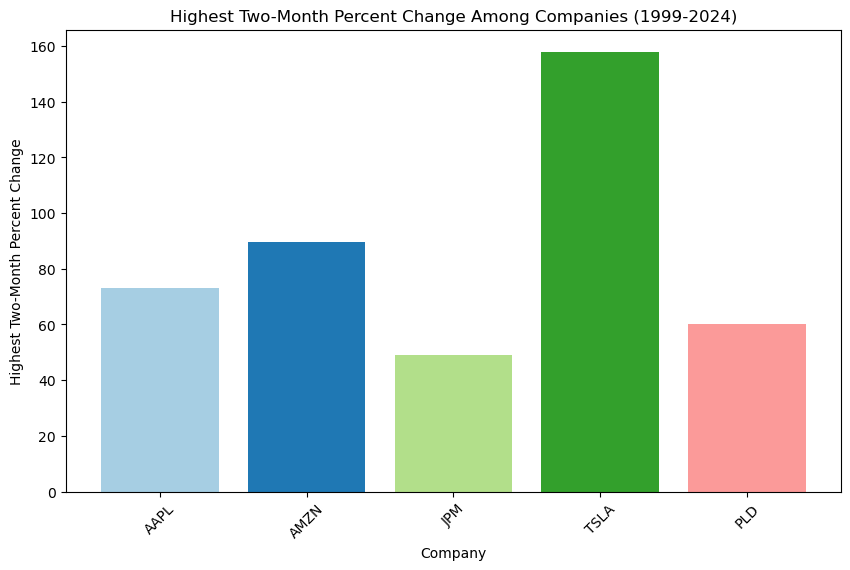

In [23]:
def insight4():
  import pandas as pd
  import os
  import matplotlib.pyplot as plt

  ##Insight 4 The highest % Change over a 2 month period between 1999-2004
  stock_data_directory = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter'
  stock_files = ['stock_data_AAPL.csv', 'stock_data_AMZN.csv', 'stock_data_JPM.csv', 'stock_data_TSLA.csv', 'stock_data_PLD.csv']
  stock_files = [os.path.join(stock_data_directory, file) for file in stock_files]

  highest_changes = []

  for stock_file in stock_files:
      if not os.path.isfile(stock_file):
          raise FileNotFoundError(f"Stock data file not found: {stock_file}")

      stock_data = pd.read_csv(stock_file)
      stock_data['date'] = pd.to_datetime(stock_data['date'])
      
      stock_data = stock_data[(stock_data['date'] >= '1999-01-01') & (stock_data['date'] <= '2024-01-01')]
      
      stock_data['percentage_change'] = stock_data['price'].pct_change(periods=2) * 100
      
      max_change = stock_data['percentage_change'].max()
      max_change_index = stock_data['percentage_change'].idxmax()
      
      start_date = stock_data.loc[max_change_index - 2, 'date'] if max_change_index >= 2 else None
      end_date = stock_data.loc[max_change_index, 'date']
      
      stock_symbol = os.path.basename(stock_file).split('_')[2].split('.')[0]
      
      highest_changes.append({
          'Stock': stock_symbol,
          'Highest Two-Month Percent Change': max_change,
          'Start Date': start_date,
          'End Date': end_date
      })

  highest_changes_df = pd.DataFrame(highest_changes)
  print(highest_changes_df)


##BAR GRAPH of the percent change of stocks comparitatively 
  labels = highest_changes_df['Stock']
  sizes = highest_changes_df['Highest Two-Month Percent Change']

  plt.figure(figsize=(10, 6))
  plt.bar(labels, sizes, color=plt.cm.Paired.colors)
  plt.xlabel('Company')
  plt.ylabel('Highest Two-Month Percent Change')
  plt.title('Highest Two-Month Percent Change Among Companies (1999-2024)')
  plt.xticks(rotation=45)
  plt.show()




############ Function Call ############
insight4()

### Insight 4 Explanation

For this insight, I wanted to relate back to our stocks. Analzying the data between stocks, I wanted to see if I would be able to find metrics that can point towards growth, whether it be pointing towards what industries have the fastest growth, or wheteher a stock's past growth is representative of its future growth. For this, my 4th insight focuses on what stock had the highest growth in any 2 month period over the years 1999-2024(a 25 year period).

What I was able to see from this insight is that our highest growth in any random 2 month period comes from the automobile company Tesla. As we can idenitify recently, electric cars are a very big talking point towards sustanability as well as luxury and comfort. To see that TSLA had such a high jump in a 2 month period can help us idenitify that if there is other stocks that have jumps like that in a short window of time, it is usually a good indicator that they will increase in value over time. We can also see AMZN and APPL coming in at 2nd and 3rd respectively, both in their early days. This helps us signify that large jumps over short periods(increased positive volatility) defintely points towards a positive overall trend, espeically considering the value of the stocks of AAPL, AMZN, and TSLA today.

   Correlation Coefficient     Slope   Intercept   R Value   P Value  \
0                -0.031926 -0.000397  229.615601 -0.031926  0.579241   

   Standard Error  
0        0.000715  
   Correlation Coefficient     Slope   Intercept   R Value   P Value  \
0                -0.031926 -0.000397  229.615601 -0.031926  0.579241   

   Standard Error  
0        0.000715  
   Correlation Coefficient     Slope   Intercept   R Value   P Value  \
0                -0.031926 -0.000397  229.615601 -0.031926  0.579241   

   Standard Error  
0        0.000715  


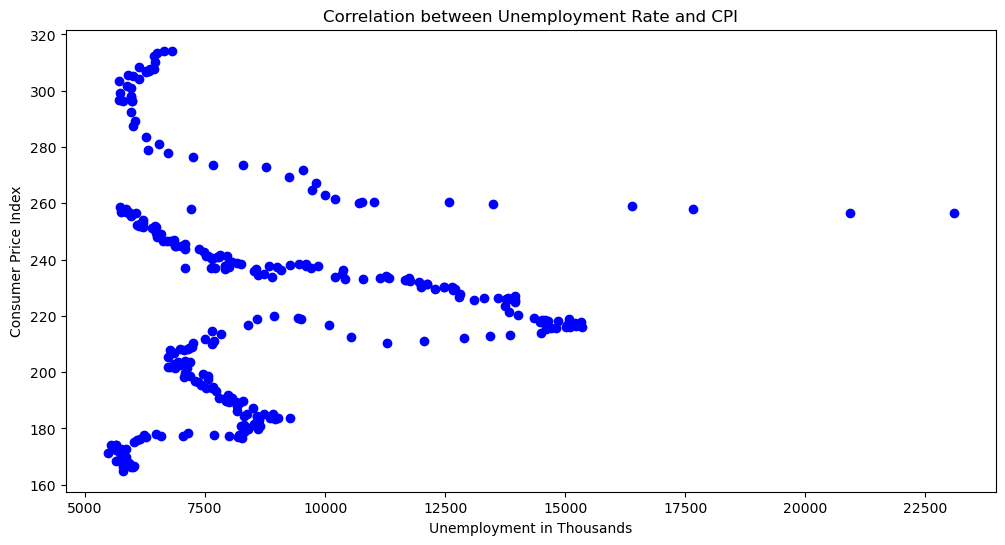

   Correlation Coefficient    Slope  Intercept   R Value   P Value  \
0                -0.010685 -0.00013  226.40771 -0.010685  0.520898   

   Standard Error  
0        0.000202  


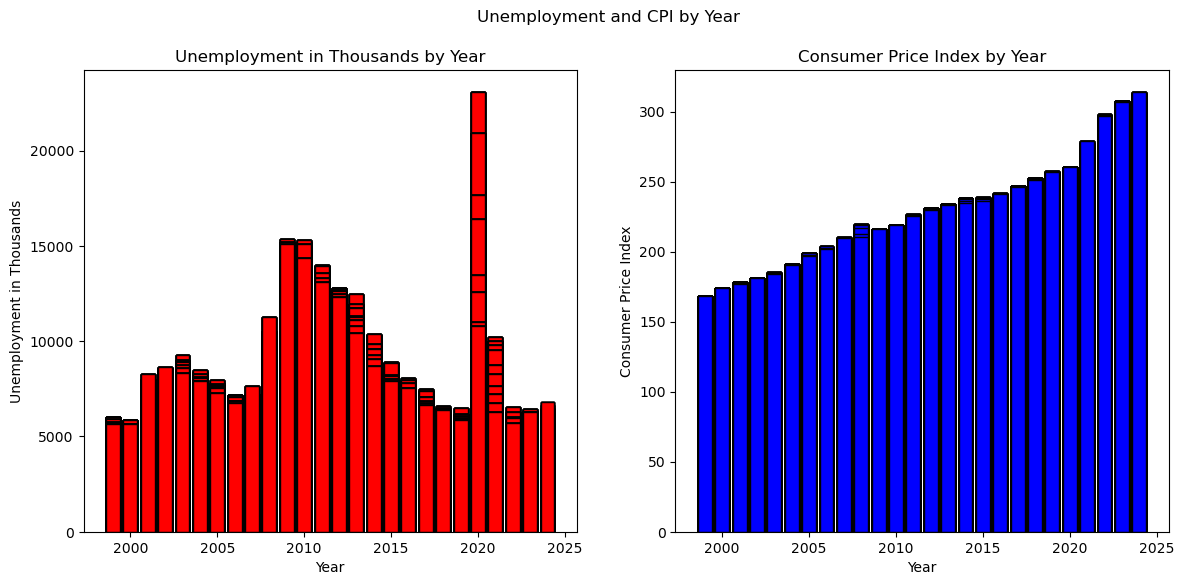

In [20]:
def insight5():
  import pandas as pd
  import os
  from scipy.stats import linregress
  import matplotlib.pyplot as plt

  ##Insight 5, analyzing the relationship between CPI and Unemployment
  unemployment_data_path = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Dataset Unemployment filter/Filtered_Unemployment_Data.csv'
  cpi_data_path = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Dataset CPI index/cpi_data_sorted_filtered.csv'

  if not os.path.isfile(unemployment_data_path):
      raise FileNotFoundError(f"Unemployment data file not found: {unemployment_data_path}")
  if not os.path.isfile(cpi_data_path):
      raise FileNotFoundError(f"CPI data file not found: {cpi_data_path}")

  unemployment_data = pd.read_csv(unemployment_data_path)
  cpi_data = pd.read_csv(cpi_data_path)

  unemployment_data['TIME_PERIOD'] = pd.to_datetime(unemployment_data['TIME_PERIOD'])
  cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])

  merged_data = pd.merge(unemployment_data, cpi_data, left_on='TIME_PERIOD', right_on='Date')

  correlation = merged_data['Unemployment in Thousands'].corr(merged_data['Consumer Price Index'])
  slope, intercept, r_value, p_value, std_err = linregress(merged_data['Unemployment in Thousands'], merged_data['Consumer Price Index'])

  results = {
      'Correlation Coefficient': correlation,
      'Slope': slope,
      'Intercept': intercept,
      'R Value': r_value,
      'P Value': p_value,
      'Standard Error': std_err
  }

  results_df = pd.DataFrame([results])
  print(results_df)



  ##Scatterplot Unemployment vs CPI
  unemployment_data = pd.read_csv(unemployment_data_path)
  cpi_data = pd.read_csv(cpi_data_path)

  unemployment_data['TIME_PERIOD'] = pd.to_datetime(unemployment_data['TIME_PERIOD'])
  cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])

  merged_data = pd.merge(unemployment_data, cpi_data, left_on='TIME_PERIOD', right_on='Date')

  correlation = merged_data['Unemployment in Thousands'].corr(merged_data['Consumer Price Index'])
  slope, intercept, r_value, p_value, std_err = linregress(merged_data['Unemployment in Thousands'], merged_data['Consumer Price Index'])

  results = {
      'Correlation Coefficient': correlation,
      'Slope': slope,
      'Intercept': intercept,
      'R Value': r_value,
      'P Value': p_value,
      'Standard Error': std_err
  }

  results_df = pd.DataFrame([results])
  print(results_df)

  results_df = pd.DataFrame([results])
  print(results_df)

  plt.figure(figsize=(12, 6))
  plt.scatter(merged_data['Unemployment in Thousands'], merged_data['Consumer Price Index'], color='blue')
  plt.xlabel('Unemployment in Thousands')
  plt.ylabel('Consumer Price Index')
  plt.title('Correlation between Unemployment Rate and CPI')
  plt.show()



  ##CPI and Unexployment Bar graph vs time
  unemployment_data = pd.read_csv(unemployment_data_path)
  cpi_data = pd.read_csv(cpi_data_path)

  unemployment_data['TIME_PERIOD'] = pd.to_datetime(unemployment_data['TIME_PERIOD'])
  cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])

  unemployment_data['Year'] = unemployment_data['TIME_PERIOD'].dt.year
  cpi_data['Year'] = cpi_data['Date'].dt.year

  merged_data = pd.merge(unemployment_data, cpi_data, left_on='Year', right_on='Year')

  correlation = merged_data['Unemployment in Thousands'].corr(merged_data['Consumer Price Index'])
  slope, intercept, r_value, p_value, std_err = linregress(merged_data['Unemployment in Thousands'], merged_data['Consumer Price Index'])

  results = {
      'Correlation Coefficient': correlation,
      'Slope': slope,
      'Intercept': intercept,
      'R Value': r_value,
      'P Value': p_value,
      'Standard Error': std_err
  }

  results_df = pd.DataFrame([results])
  print(results_df)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  ax1.bar(merged_data['Year'], merged_data['Unemployment in Thousands'], color='red', edgecolor='black')
  ax1.set_title('Unemployment in Thousands by Year')
  ax1.set_xlabel('Year')
  ax1.set_ylabel('Unemployment in Thousands')

  ax2.bar(merged_data['Year'], merged_data['Consumer Price Index'], color='blue', edgecolor='black')
  ax2.set_title('Consumer Price Index by Year')
  ax2.set_xlabel('Year')
  ax2.set_ylabel('Consumer Price Index')

  plt.suptitle('Unemployment and CPI by Year')
  plt.show()





############ Function Call ############
insight5()

### Insight 5 Explanation

My 5th insight was to look into our two main variables, CPI and the Unemployment index. These are 2 very key economic indicators, and they help countries like ours make big decisions for future months. As we have discussed, the unemployment index represents the number of unemployed people per month, but the CPI(Consumer Price Index) compares the prices of various goods in "actual dollars" to what they wouldve cost during a pat period of time. For example lets say a basket of groceries can be bought today for 10 USD, if it can be bought next month for 15USD, the CPI has gone up.

To analyze my data I employed the use of graphs and statistics here. I created a bar graph of the unemployment in thousands by year, to compare it side by side with the CPI per year. Here we can see 2 general trends. Firstly, it is an extremely rare occurance for the CPI to go down between 2 years(as we see between 2008 and 2009.) Secondly, no matter how high the unemployment is, we see that the CPI(prices) are still generally trending upwards. This provides some valueable insight because we can now realize that even during periods of high unemployment, where people are tight for money, prices seem to continue to trend upwards. This is further confirmed by statistical estimates provided, showing a correlation coefficant closer to 0(no correlation) as well as a p-value > 0.05, meaning little statistical significance.

## Data Visualizations

In [ ]:
def visual1():
  pass
  ##PRESENT IN:
  #Insight 1: 5 line-Graphs with 2 trendlines each
  #Insight 4: One Bar Graph
  #Insight 5: One histogram, and one scatterplot





############ Function Call ############
visual1()

### Visualization 1 Explanation

Insert explanation here

In [ ]:
def visual2():
  pass
  ##PRESENT IN:
  #Insight 1: 5 line-Graphs with 2 trendlines each
  #Insight 4: One Bar Graph
  #Insight 5: One histogram, and one scatterplot





############ Function Call ############
visual2()

### Visualization 2 Explanation

Insert explanation here

In [ ]:
def visual3():
  pass
  ##PRESENT IN:
  #Insight 1: 5 line-Graphs with 2 trendlines each
  #Insight 4: One Bar Graph
  #Insight 5: One histogram, and one scatterplot





############ Function Call ############
visual3()

### Visualization 3 Explanation

Insert explanation here

## Summary Files

In [26]:
def summary1():
  ##SUMMARY FILE IS AGGRIGATED BY YEAR, TSLA DATA NOT AVALIBLE BEFORE 2010 from API
  import pandas as pd
  import os

  unemployment_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Dataset Unemployment filter/Filtered_Unemployment_Data.csv')
  cpi_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Dataset CPI index/cpi_data_sorted_filtered.csv')
  aapl_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter/stock_data_AAPL.csv')
  amzn_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter/stock_data_AMZN.csv')
  jpm_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter/stock_data_JPM.csv')
  tsla_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter/stock_data_TSLA.csv')
  pld_data = pd.read_csv('/Users/vedsanjanwala/Documents/CS 2316/CSProj/Stockdata filter/stock_data_PLD.csv')

  unemployment_data['TIME_PERIOD'] = pd.to_datetime(unemployment_data['TIME_PERIOD'])
  cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])
  aapl_data['date'] = pd.to_datetime(aapl_data['date'])
  amzn_data['date'] = pd.to_datetime(amzn_data['date'])
  jpm_data['date'] = pd.to_datetime(jpm_data['date'])
  tsla_data['date'] = pd.to_datetime(tsla_data['date'])
  pld_data['date'] = pd.to_datetime(pld_data['date'])

  unemployment_data['Year'] = unemployment_data['TIME_PERIOD'].dt.year
  cpi_data['Year'] = cpi_data['Date'].dt.year
  aapl_data['Year'] = aapl_data['date'].dt.year
  amzn_data['Year'] = amzn_data['date'].dt.year
  jpm_data['Year'] = jpm_data['date'].dt.year
  tsla_data['Year'] = tsla_data['date'].dt.year
  pld_data['Year'] = pld_data['date'].dt.year

  unemployment_data = unemployment_data[unemployment_data['Year'] >= 1999]
  cpi_data = cpi_data[cpi_data['Year'] >= 1999]
  aapl_data = aapl_data[aapl_data['Year'] >= 1999]
  amzn_data = amzn_data[amzn_data['Year'] >= 1999]
  jpm_data = jpm_data[jpm_data['Year'] >= 1999]
  tsla_data = tsla_data[tsla_data['Year'] >= 1999]
  pld_data = pld_data[pld_data['Year'] >= 1999]

  unemployment_grouped = unemployment_data.groupby('Year').mean(numeric_only=True).reset_index()
  cpi_grouped = cpi_data.groupby('Year').mean(numeric_only=True).reset_index()
  aapl_grouped = aapl_data.groupby('Year').mean(numeric_only=True).reset_index()
  amzn_grouped = amzn_data.groupby('Year').mean(numeric_only=True).reset_index()
  jpm_grouped = jpm_data.groupby('Year').mean(numeric_only=True).reset_index()
  tsla_grouped = tsla_data.groupby('Year').mean(numeric_only=True).reset_index()
  pld_grouped = pld_data.groupby('Year').mean(numeric_only=True).reset_index()

  unemployment_grouped['Source'] = 'Unemployment'
  cpi_grouped['Source'] = 'CPI'
  aapl_grouped['Source'] = 'AAPL'
  amzn_grouped['Source'] = 'AMZN'
  jpm_grouped['Source'] = 'JPM'
  tsla_grouped['Source'] = 'TSLA'
  pld_grouped['Source'] = 'PLD'

  merged_data = unemployment_grouped.merge(cpi_grouped, on='Year', how='outer', suffixes=('_unemployment', '_cpi'))
  merged_data = merged_data.merge(aapl_grouped, on='Year', how='outer', suffixes=('', '_aapl'))
  merged_data = merged_data.merge(amzn_grouped, on='Year', how='outer', suffixes=('', '_amzn'))
  merged_data = merged_data.merge(jpm_grouped, on='Year', how='outer', suffixes=('', '_jpm'))
  merged_data = merged_data.merge(tsla_grouped, on='Year', how='outer', suffixes=('', '_tsla'))
  merged_data = merged_data.merge(pld_grouped, on='Year', how='outer', suffixes=('', '_pld'))

  cols = ['Year'] + [col for col in merged_data.columns if col != 'Year']
  merged_data = merged_data[cols]

  merged_data = merged_data.round(2)

  summary_file_path = '/Users/vedsanjanwala/Documents/CS 2316/CSProj/Diagrams/Summary_File.csv'
  merged_data.to_csv(summary_file_path, index=False)
  print(merged_data)









############ Function Call ############
summary1()

    Year  Unemployment in Thousands  PCT_CHANGE Source_unemployment  \
0   1999                    5845.90       -0.74        Unemployment   
1   2000                    5685.08        0.01        Unemployment   
2   2001                    6829.67        3.27        Unemployment   
3   2002                    8375.33        0.39        Unemployment   
4   2003                    8770.33       -0.30        Unemployment   
5   2004                    8139.67       -0.37        Unemployment   
6   2005                    7579.17       -0.70        Unemployment   
7   2006                    6991.25       -0.59        Unemployment   
8   2007                    7073.08        1.06        Unemployment   
9   2008                    8948.17        3.36        Unemployment   
10  2009                   14294.50        2.49        Unemployment   
11  2010                   14807.75       -0.40        Unemployment   
12  2011                   13738.50       -0.75        Unemployment   
13  20

# Cited Sources

If you used any additional sources to complete your Data Analysis section, list them here:


*   Example Module Documentation
*   Example Stack Overflow Assistance



# Video Presentation

If you uploaded your Video Presentation to Bluejeans, YouTube, or any other streaming services, please provide the link here:


https://youtu.be/JCcKF3BtOC0

Make sure the video sharing permissions are accessible for anyone with the provided link.

# Submission

Prior to submitting your notebook to Gradescope, be sure to <b>run all functions within this file</b>. We will not run your functions ourselves, so we must see your outputs within this file in order to receive full credit.
